## Installing required libraries

In [1]:
!pip install gensim
!pip install portalocker


## Importing required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import warnings
def warn(*args,**kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tinonturjamajumder/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tinonturjamajumder/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Newly adapted import Libraries

In [3]:
import logging
from gensim.models import Word2Vec
from collections import defaultdict

from sklearn.manifold import TSNE

from IPython.core.display import display,SVG

from torchtext.vocab import GloVe,vocab
from torchdata.datapipes.iter import IterableWrapper,Mapper
from torchtext.datasets import AG_NEWS
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset



Define a function to plot word embeddings in a 2d space

In [4]:
def plot_embeddings(word_embeddings,vocab = vocab):
    tsne = TSNE(n_components = 2,random_state = 0)
    word_embeddings_2d = tsne.fit_transform(word_embeddings)


    # Plotting the results with labels from vocab
    plt.figure(figsize = (15,15))

    for i, word in enumerate(vocab.get_itos()): # assuming vocab.itos gives the list of words in your vocab
        plt.scatter(word_embeddings_2d[i,0],word_embeddings_2d[i,1])
        plt.annotate(word, (word_embeddings_2d[i,0], word_embeddings_2d[i,1]))

    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.title("Word Embeddings visualized with t-SNE")
    plt.show()
        

Define a function that returns similar words to a specific word by calculating Cosine Distance

In [5]:
# The function returns the most similar words to a target word by calculating word vectors cosine distance

def find_simiar_words(word,word_embeddings,top_k = 5):
    if word not in word_embeddings:
        print("Word not found in embeddings")

        return []

    # Get the embedding for the given word
    target_embedding = word_embeddings[word]

    # Calculate cosine similarities between the target word and all other words
    similarities = {}

    for w, embedding in word_embeddings.items():
        if w != word:
            similarity = torch.dot(target_embedding,embedding) / (
                torch.norm(target_embedding) * torch.norm(embedding)
            )

            similarities[w] = similarity.item()

    # sort the similarities in descending order
    sorted_similarities = sorted(similarities.items(),key = lambda x: x[1],reverse = True)


    # Return the top k similar words
    most_similar_words = [w for w,_ in sorted_similarities[:top_k]]

    return most_similar_words

## Train Model

In [6]:

def train_model(model,dataloader,loss_fn, optimizer, num_epochs = 100):

    """Train the model for the specified number of epochs
    
    Args:
        model: the pytorch model to be trained.
        dataloader: DataLoader provided data for training
        loss_fn: Loss Function,
        optimizer: optimizer for updating model's weights
        num_epochs: number of epochs to train the model for

    Returns:
        model: The trainded model
        epoch_losses: list of average losses for each epoch
    
    
    """

    # List to store running loss
    loss_list = []

    for epoch in tqdm(range(num_epochs)):

        # Storing running loss values for the current epoch
        running_loss = 0.0

        # using tqdm for a progress bar
        for idx, samples in enumerate(dataloader):
            # 0. Optimizer
            optimizer.zero_grad()

            # Check for embedding_bag layer in the model
            if any(isinstance(module,nn.EmbeddingBag) for _,module in model.named_modules()):
                target, context, offsets = samples

                # 1. Forward pass
                predicted = model(context, offsets)

            # check for embedding layer in the model
            elif any(isinstance(module,nn.Embedding) for _,module in model.named_modules()):
                target,context = samples

                # 1. Forward Pass
                predicted  = model(context)

            # 2. Loss Calculation

            loss = loss_fn(predicted,target)

            # 3. backward Propagation
            loss.backward()

            # 4. Gradient clipping is a way to limit (clip) the gradients’ magnitude, ensuring they stay within a reasonable range.
            torch.nn.utils.clip_grad_norm_(model.parameters(),0.1)

            # 5. optimizer step
            optimizer.step()

            # 6. accumulate the loss
            running_loss +=loss.item()


        # Append average loss for the epoch
        loss_list.append(running_loss/len(dataloader))

    return model,loss_list
                
    

## Create and train Word2Vec models

In [7]:
toy_data = """I wish I was little bit taller
I wish I was a baller
She wore a small black dress to the party
The dog chased a big red ball in the park
He had a huge smile on his face when he won the race
The tiny kitten played with a fluffy toy mouse
The team celebrated their victory with a grand parade
She bought a small, delicate necklace for her sister
The mountain peak stood majestic and tall against the clear blue sky
The toddler took small, careful steps as she learned to walk
The house had a spacious backyard with a big swimming pool
He felt a sense of accomplishment after completing the challenging puzzle
The chef prepared a delicious, flavorful dish using fresh ingredients
The children played happily in the small, cozy room
The book had an enormous impact on readers around the world
The wind blew gently, rustling the leaves of the tall trees
She painted a beautiful, intricate design on the small canvas
The concert hall was filled with thousands of excited fans
The garden was adorned with colorful flowers of all sizes
I hope to achieve great success in my chosen career path
The skyscraper towered above the city, casting a long shadow
He gazed in awe at the breathtaking view from the mountaintop
The artist created a stunning masterpiece with bold brushstrokes
The baby took her first steps, a small milestone that brought joy to her parents
The team put in a tremendous amount of effort to win the championship
The sun set behind the horizon, painting the sky in vibrant colors
The professor gave a fascinating lecture on the history of ancient civilizations
The house was filled with laughter and the sound of children playing
She received a warm, enthusiastic welcome from the audience
The marathon runner had incredible endurance and determination
The child's eyes sparkled with excitement upon opening the gift
The ship sailed across the vast ocean, guided by the stars
The company achieved remarkable growth in a short period of time
The team worked together harmoniously to complete the project
The puppy wagged its tail, expressing its happiness and affection
She wore a stunning gown that made her feel like a princess
The building had a grand entrance with towering columns
The concert was a roaring success, with the crowd cheering and clapping
The baby took a tiny bite of the sweet, juicy fruit
The athlete broke a new record, achieving a significant milestone in her career
The sculpture was a masterpiece of intricate details and craftsmanship
The forest was filled with towering trees, creating a sense of serenity
The children built a small sandcastle on the beach, their imaginations running wild
The mountain range stretched as far as the eye could see, majestic and awe-inspiring
The artist's brush glided smoothly across the canvas, creating a beautiful painting
She received a small token of appreciation for her hard work and dedication
The orchestra played a magnificent symphony that moved the audience to tears
The flower bloomed in vibrant colors, attracting butterflies and bees
The team celebrated their victory with a big, extravagant party
The child's laughter echoed through the small room, filling it with joy
The sunflower stood tall, reaching for the sky with its bright yellow petals
The city skyline was dominated by tall buildings and skyscrapers
The cake was adorned with a beautiful, elaborate design for the special occasion
The storm brought heavy rain and strong winds, causing widespread damage
The small boat sailed peacefully on the calm, glassy lake
The artist used bold strokes of color to create a striking and vivid painting
The couple shared a passionate kiss under the starry night sky
The mountain climber reached the summit after a long and arduous journey
The child's eyes widened in amazement as the magician performed his tricks
The garden was filled with the sweet fragrance of blooming flowers
The basketball player made a big jump and scored a spectacular slam dunk
The cat pounced on a small mouse, displaying its hunting instincts
The mansion had a grand entrance with a sweeping staircase and chandeliers
The raindrops fell gently, creating a rhythmic patter on the roof
The baby took a big step forward, encouraged by her parents' applause
The actor delivered a powerful and emotional performance on stage
The butterfly fluttered its delicate wings, mesmerizing those who watched
The company launched a small-scale advertising campaign to test the market
The building was constructed with strong, sturdy materials to withstand earthquakes
The singer's voice was powerful and resonated throughout the concert hall
The child built a massive sandcastle with towers, moats, and bridges
The garden was teeming with a variety of small insects and buzzing bees
The athlete's muscles were well-developed and strong from years of training
The sun cast long shadows as it set behind the mountains
The couple exchanged heartfelt vows in a beautiful, intimate ceremony
The dog wagged its tail vigorously, a sign of excitement and happiness
The baby let out a tiny giggle, bringing joy to everyone around"""


Now prepare the data by tokenizing it and made it into vocab

In [8]:
tokenizer = get_tokenizer('basic_english')
tokenized_toy_data = tokenizer(toy_data)

vocab = build_vocab_from_iterator(map(tokenizer,toy_data.split()),specials = ["<unk>"])
vocab.set_default_index(vocab["<unk>"])



In [9]:
tokenized_toy_data[0]

'i'

Lets check how a sentence looks like after tokenization and numericalization

In [10]:
# Test
sample_sentence = "I wish I was a baller"
tokenized_sample = tokenizer(sample_sentence)
tokenized_sample

['i', 'wish', 'i', 'was', 'a', 'baller']

In [11]:
number_list = [vocab[words] for words in tokenized_sample]
number_list
    

[20, 108, 20, 7, 2, 133]

write a function to apply numericalization on all tokens

In [12]:
text_pipeline = lambda tokens: [vocab[token] for token in tokens]


## Continuous Bag of Words (CBOW)

For the continuous bag of words model, use a 'context' to predict a target word. The `context` is typically a set of surrounding words. For example, if your context window is of size 2, then you take two words before and two words after the target words as context.

In [13]:
CONTEXT_SIZE = 2

cbow_data = []

# modified code

for i in range(CONTEXT_SIZE,len(tokenized_toy_data)-CONTEXT_SIZE):

    # context word
    cbow_data.append((([tokenized_toy_data[i-j-1] for j in range(CONTEXT_SIZE)]+[tokenized_toy_data[i+j+1] for j in range(CONTEXT_SIZE)]),
    tokenized_toy_data[i]))
    

In [14]:
type(cbow_data)

list

In [15]:
len(cbow_data)

890

In [16]:
cbow_data[:10]

[(['wish', 'i', 'was', 'little'], 'i'),
 (['i', 'wish', 'little', 'bit'], 'was'),
 (['was', 'i', 'bit', 'taller'], 'little'),
 (['little', 'was', 'taller', 'i'], 'bit'),
 (['bit', 'little', 'i', 'wish'], 'taller'),
 (['taller', 'bit', 'wish', 'i'], 'i'),
 (['i', 'taller', 'i', 'was'], 'wish'),
 (['wish', 'i', 'was', 'a'], 'i'),
 (['i', 'wish', 'a', 'baller'], 'was'),
 (['was', 'i', 'baller', 'she'], 'a')]

In [17]:
context,target = cbow_data[1]
context_vocab= vocab(context)
target_vocab= vocab[target]
context_vocab,target_vocab

([20, 108, 272, 136], 7)

In [18]:
text_pipeline(context)

[20, 108, 272, 136]

## Set up the collate function

In [19]:
def collate_function(batch):

    """Collate function will take tokens into account and convert it into vocab tensor"""

    target_list, context_list, offsets = [],[],[0]

    for context,target in batch:
        
        target_list.append(vocab[target])
        processed_context = torch.tensor(text_pipeline(context),dtype = torch.int64)
        context_list.append(processed_context)
        # context_list.append(vocab(context)) # It will work fine if the context data comes as separate word
        offsets.append(processed_context.shape[0])

    target_list = torch.tensor(target_list)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    context_list  = torch.cat(context_list)
    return target_list,context_list,offsets
        

In [20]:
target_list, context_list,offsets = collate_function(cbow_data[:10])
print(f"target_list(Tokenized target words): {target_list} , \ncontext_list(Surrounding context words): {context_list} , \noffsets(Starting indexes of context words for each target): {offsets} ")

target_list(Tokenized target words): tensor([ 20,   7, 272, 136, 376,  20, 108,  20,   7,   2]) , 
context_list(Surrounding context words): tensor([108,  20,   7, 272,  20, 108, 272, 136,   7,  20, 136, 376, 272,   7,
        376,  20, 136, 272,  20, 108, 376, 136, 108,  20,  20, 376,  20,   7,
        108,  20,   7,   2,  20, 108,   2, 133,   7,  20, 133,  14]) , 
offsets(Starting indexes of context words for each target): tensor([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36]) 


In [21]:
BATCH_SIZE  = 64

# the dataset should be a list, which consists of a tuple. one is context, and another one is target
dataloader_cbow = DataLoader(dataset=cbow_data,
                            batch_size = BATCH_SIZE,
                            shuffle = True,
                            collate_fn = collate_function)

print(dataloader_cbow)

The CBOW model shown here starts with an embeddingbag layer, which takes a variable length list of context word indices and produces an averaged embedding of size embed_dim. This embedding is then passed through a linera layer that reduces its dimension to embed_dim/2. After applying a ReLU activaiton, the output is processed by another linear layer, transforming it to match the vocabulary size, thus allowing the model to predict the probabiltiy of any word form the vocabulary as the target word, The overall flow moves from contextual words indices to predicting the central word in the Continuous Bag of Words approach.

In [22]:
class CBOW(nn.Module):

    # Initialize the CBOW model
    def __init__(self,vocab_size, embed_dim, num_class):

        super().__init__()

        # Define the embedding layer using nn.EmbeddingBag
        # It outputs the average of context words embeddings

        self.embeddings = nn.EmbeddingBag(vocab_size, embed_dim,sparse = False)

        # Define the first linear layer with input size embed_dim and output size embed_dim/2

        self.linear1 = nn.Linear(embed_dim,embed_dim//2)

        # Define the fully connected layer with input size embed_dim/2 and output size vocab_size
        self.fc = nn.Linear(embed_dim//2,vocab_size)


        self.init_weights()

    def init_weights(self):
        # initialize the weights of the embedding layer
        initrange = 0.5

        self.embeddings.weight.data.uniform_(-initrange,initrange)

        # initialize the weights of the fully connected layer
        self.fc.weight.data.uniform_(-initrange,initrange)

        # initialize the biases of the fully connected layer
        self.fc.bias.data.zero_()

    def forward(self,text,offsets):

        # pass the input text and offsets throught the embedding layer
        
        out = self.embeddings(text,offsets)

        # Apply the ReLU activation function to the output of the first linear layer
        out = torch.relu(self.linear1(out))

        # Pass the output of the ReLU activation through the fully connected layer
        return self.fc(out)

In [23]:
vocab_size = len(vocab)
embed_dim = 24
model_cbow = CBOW(vocab_size,embed_dim,vocab_size)

In [24]:
vocab_size

427

In [25]:
_,context,offsets = collate_function(cbow_data[:10])

output = model_cbow(context,offsets)

In [26]:
output.shape

torch.Size([10, 427])

In [27]:
_.shape,context.shape

(torch.Size([10]), torch.Size([40]))

Define the loss function optimizer and schedule rate

In [28]:
loss_fn = torch.nn.CrossEntropyLoss()

LR = 0.5

optimizer = torch.optim.SGD(model_cbow.parameters(),
                           lr = LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma = 0.1)

In [29]:
# pip install tqdm


In [30]:
from tqdm.auto import tqdm

In [31]:
model_cbow,epoch_losses = train_model(model = model_cbow,dataloader = dataloader_cbow,loss_fn = loss_fn,optimizer = optimizer)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 0, 'epochs')

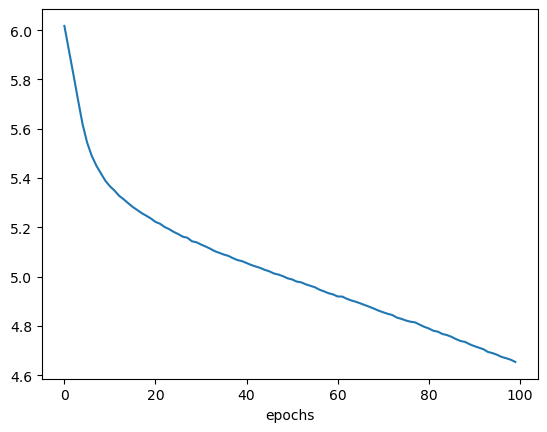

In [32]:
plt.plot(epoch_losses)
plt.xlabel("epochs")

The model's weight are the actual word embeddings. You can load them into a numpy array

In [33]:
word_embeddings = model_cbow.embeddings.weight.detach().cpu().numpy()

In [34]:
word = 'baller'
word_index = vocab.get_stoi()[word] # getting the index of the word in the vocab

In [35]:
word_index

133

In [36]:
print(word_embeddings[word_index])

[ 0.40475744  0.03386392 -0.24520071  0.2583092  -0.26195553  0.16495296
  0.21652143 -0.4300687   0.4193981  -0.1182853   0.07271416  0.2575282
 -0.44840637  0.39973477 -0.49771482  0.29161835 -0.40743065  0.4431063
  0.32402793  0.35993314  0.10795491  0.46371645 -0.02467927  0.1882335 ]


In [37]:
#plot_embeddings(word_embeddings,vocab = vocab)

## Skip-gram Model

The Skip-gram model is one of the two main architectures used in word2vec, a popular technique for learning word embeddings. In the Skip-gram model, the goal is to predict the surrounding words (context) given a central word (target). The main idea behind this model is that words that appear in similar contexts tend to have similar meanings.  Consider this example:

**I was little bit taller,**

Assuming a context window size of 2, the words in red represent the context, while the word highlighted in blue signifies the target:

**<span style="color:red;"> I was</span> <span style="color:blue;">little</span> <span style="color:red;">bit taller, </span>**

### Window the Skip-gram:

Training the Skip-gram model using the actual context can be computationally expensive. This is because it involves predicting probabilities for each word in the vocabulary for each position in the context as opposed to CBOW that predicts the probabilities for each word in the vocabulary for the target word only. To mitigate this, several approximation techniques are employed.

One common approximation technique is to break the full context into smaller parts and predict them one at a time. This not only simplifies the prediction task but also helps in better training as it provides multiple training examples from a single context-target pair.

### Using the first row of the table as an example:


For the example above the target word is **"little"**. The full context for this target word is:
**I was bit taller**

In the approximation, instead of using the full context to predict the target, you should break it down. There are four approximations in this example:
1. Approximation 1: **I**
2. Approximation 2: **was**
3. Approximation 3: **bit**
4. Approximation 4: **taller**

For each approximation, the Skip-gram model would aim to predict the target word "little" using just that part of the context. This means, for the first approximation, the model will try to predict "little" using only the word "I". For the second approximation, it will try using only the word "was," and so on.

In conclusion, the Skip-gram model aims to understand word relationships by predicting the context from a given target word. Approximation techniques, like the one illustrated, help simplify the training process and make it more efficient.


In [38]:
CONTEXT_SIZE =2

for i in range(CONTEXT_SIZE,len(tokenized_toy_data)-CONTEXT_SIZE):

    target = [tokenized_toy_data[i-j-1] for j in range(CONTEXT_SIZE)] + [tokenized_toy_data[i+j+1] for j in range(CONTEXT_SIZE)] 

    context = tokenized_toy_data[i]

    for
    

SyntaxError: expected ':' (466151282.py, line 3)